In [1]:
import os

# setting the current working directory
os.chdir(r'C:\Users\bhaga\Documents\Skunkworks\Volunteer\Skeleton_Action_Recognition')


In [2]:
# checking if tensorflow is using GPU

import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# checking if keras is using GPU

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/device:GPU:0']

In [4]:
import numpy as np
import math
from keras import optimizers
from utils import *
from model import *

In [5]:
# Dataset downloaded from https://www3.cs.stonybrook.edu/~kyun/research/kinect_interaction/index.html

# All the files have been unzipped manually and stored locally
# About:
# The SBU Kinect Interaction dataset is a Kinect captured human activity recognition dataset depicting two person interaction. 
# Seven participants, 21 sets, ~300 interactions
# A color image, a depth map, and extracted skeletons (i.e. 3D coordinates of 15 joints from each person) at each frame
# Classes: approaching, departing, pushing, kicking, punching, exchanging an object, hugging,and shaking hands.
# Source: https://www3.cs.stonybrook.edu/~kyun/papers/kiwon_hau3d12_poster.pdf

SBU_dir = r'C:\Users\bhaga\Documents\Skunkworks\Volunteer\Skeleton_Action_Recognition\SBUDATA'

In [6]:
train, test = get_datasets(SBU_dir)

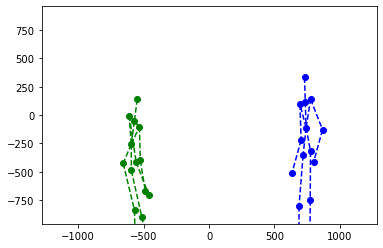

<Figure size 432x288 with 0 Axes>

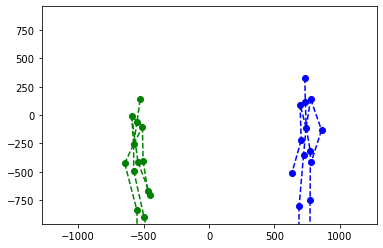

<Figure size 432x288 with 0 Axes>

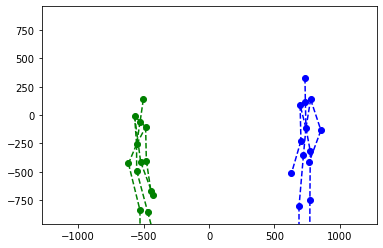

<Figure size 432x288 with 0 Axes>

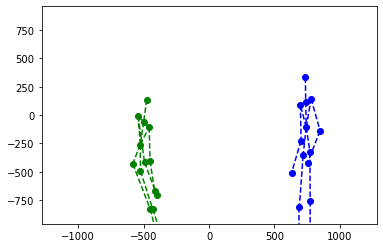

<Figure size 432x288 with 0 Axes>

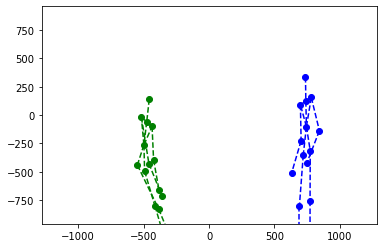

<Figure size 432x288 with 0 Axes>

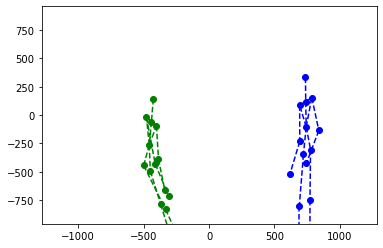

<Figure size 432x288 with 0 Axes>

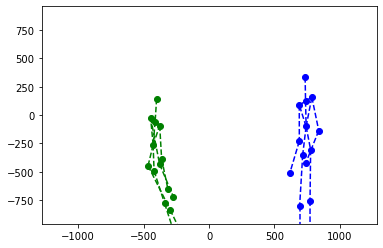

<Figure size 432x288 with 0 Axes>

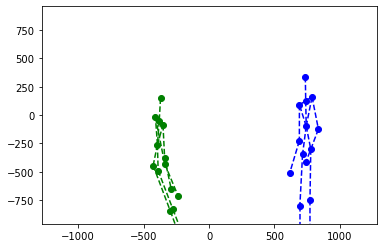

<Figure size 432x288 with 0 Axes>

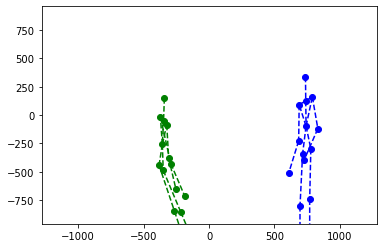

<Figure size 432x288 with 0 Axes>

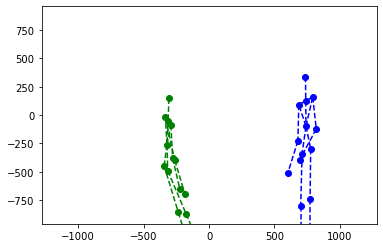

<Figure size 432x288 with 0 Axes>

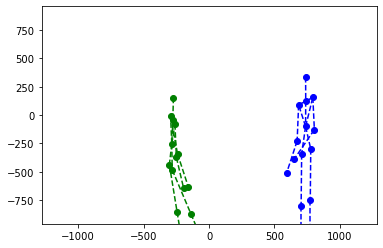

<Figure size 432x288 with 0 Axes>

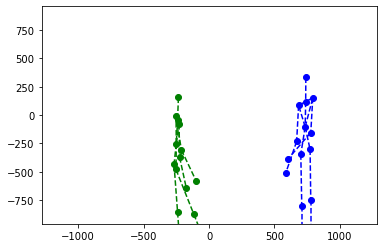

<Figure size 432x288 with 0 Axes>

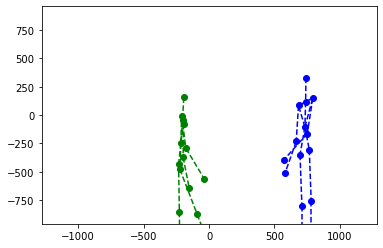

<Figure size 432x288 with 0 Axes>

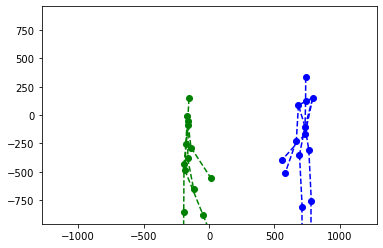

<Figure size 432x288 with 0 Axes>

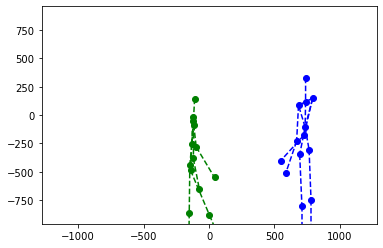

<Figure size 432x288 with 0 Axes>

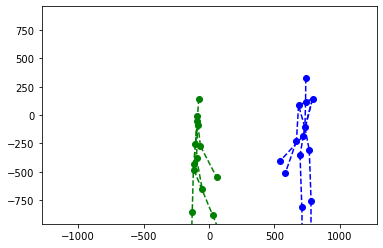

<Figure size 432x288 with 0 Axes>

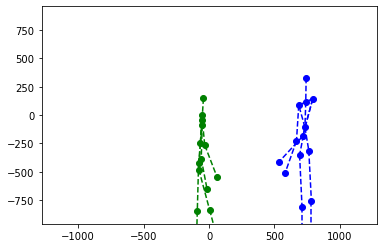

<Figure size 432x288 with 0 Axes>

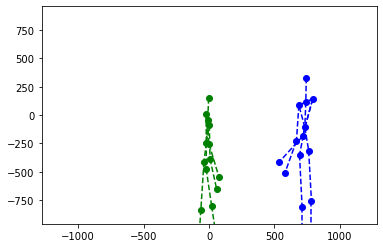

<Figure size 432x288 with 0 Axes>

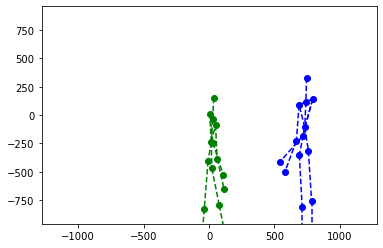

<Figure size 432x288 with 0 Axes>

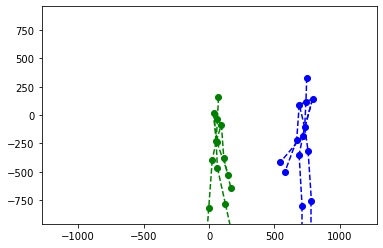

<Figure size 432x288 with 0 Axes>

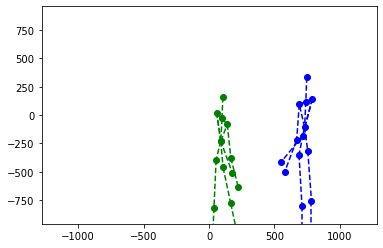

<Figure size 432x288 with 0 Axes>

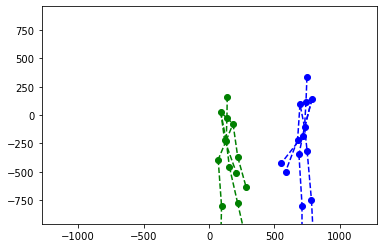

<Figure size 432x288 with 0 Axes>

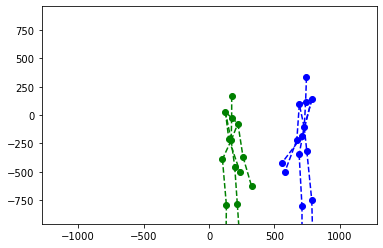

<Figure size 432x288 with 0 Axes>

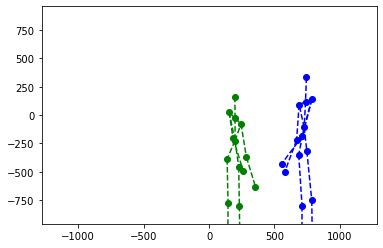

<Figure size 432x288 with 0 Axes>

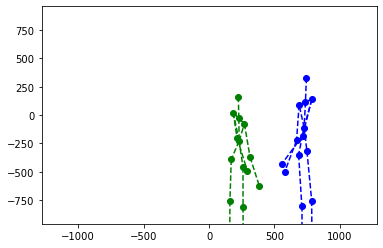

<Figure size 432x288 with 0 Axes>

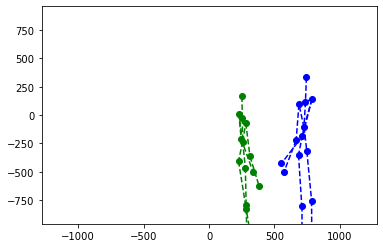

<Figure size 432x288 with 0 Axes>

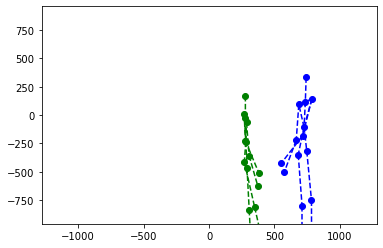

<Figure size 432x288 with 0 Axes>

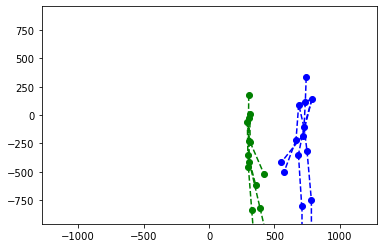

<Figure size 432x288 with 0 Axes>

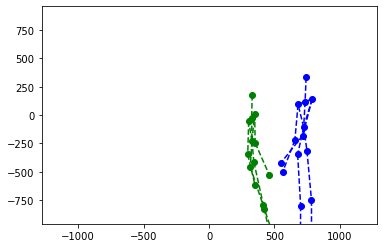

<Figure size 432x288 with 0 Axes>

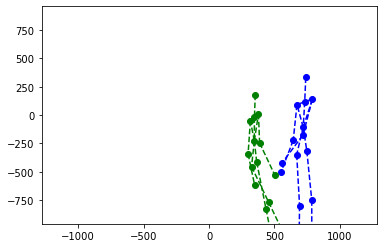

<Figure size 432x288 with 0 Axes>

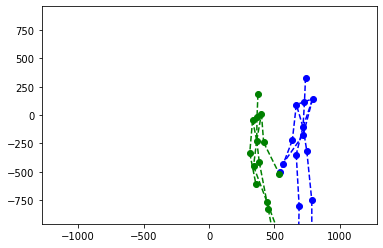

<Figure size 432x288 with 0 Axes>

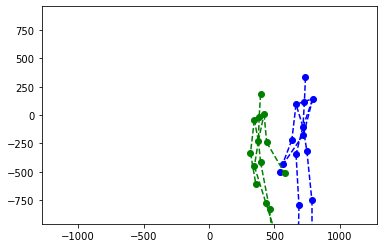

<Figure size 432x288 with 0 Axes>

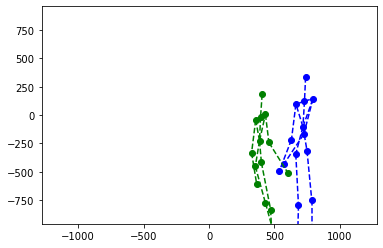

<Figure size 432x288 with 0 Axes>

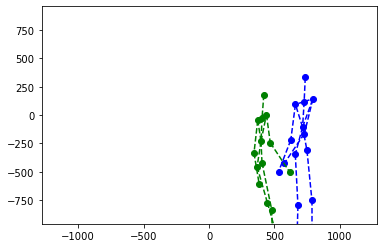

<Figure size 432x288 with 0 Axes>

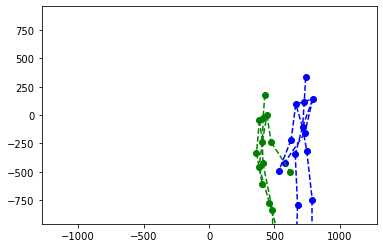

<Figure size 432x288 with 0 Axes>

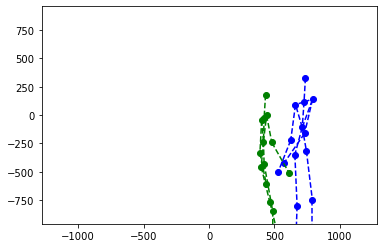

<Figure size 432x288 with 0 Axes>

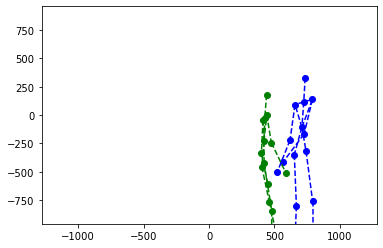

<Figure size 432x288 with 0 Axes>

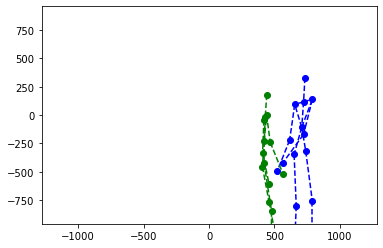

<Figure size 432x288 with 0 Axes>

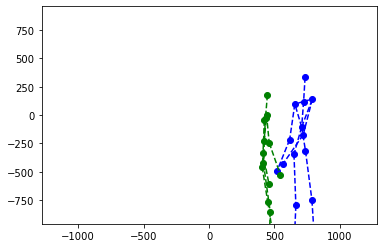

<Figure size 432x288 with 0 Axes>

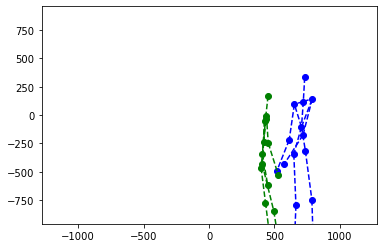

<Figure size 432x288 with 0 Axes>

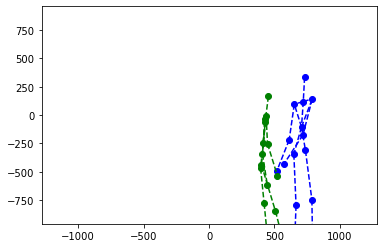

<Figure size 432x288 with 0 Axes>

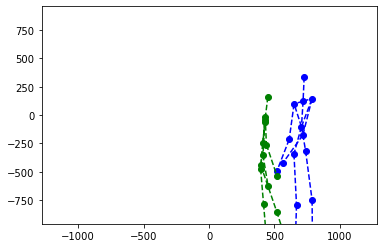

<Figure size 432x288 with 0 Axes>

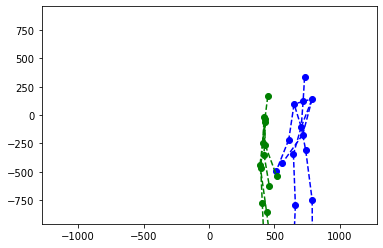

<Figure size 432x288 with 0 Axes>

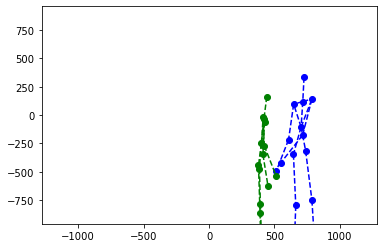

<Figure size 432x288 with 0 Axes>

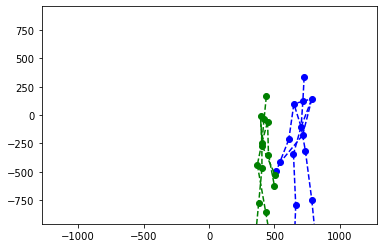

<Figure size 432x288 with 0 Axes>

In [7]:
display_sample(train[1][0])

In [9]:
lr=0.001
adam = optimizers.Adam(lr)
# sgd = optimizers.SGD(lr=lrt, momentum=0.9, decay=1e-4, nesterov=False)
model = multi_obj()
model.compile(adam, loss='mean_squared_error')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_j_0 (InputLayer)            (None, 16, 15, 3)    0                                            
__________________________________________________________________________________________________
inp_j_diff_0 (InputLayer)       (None, 16, 15, 3)    0                                            
__________________________________________________________________________________________________
inp_j_1 (InputLayer)            (None, 16, 15, 3)    0                                            
__________________________________________________________________________________________________
inp_j_diff_1 (InputLayer)       (None, 16, 15, 3)    0                                            
____________________________________________________________________________________________

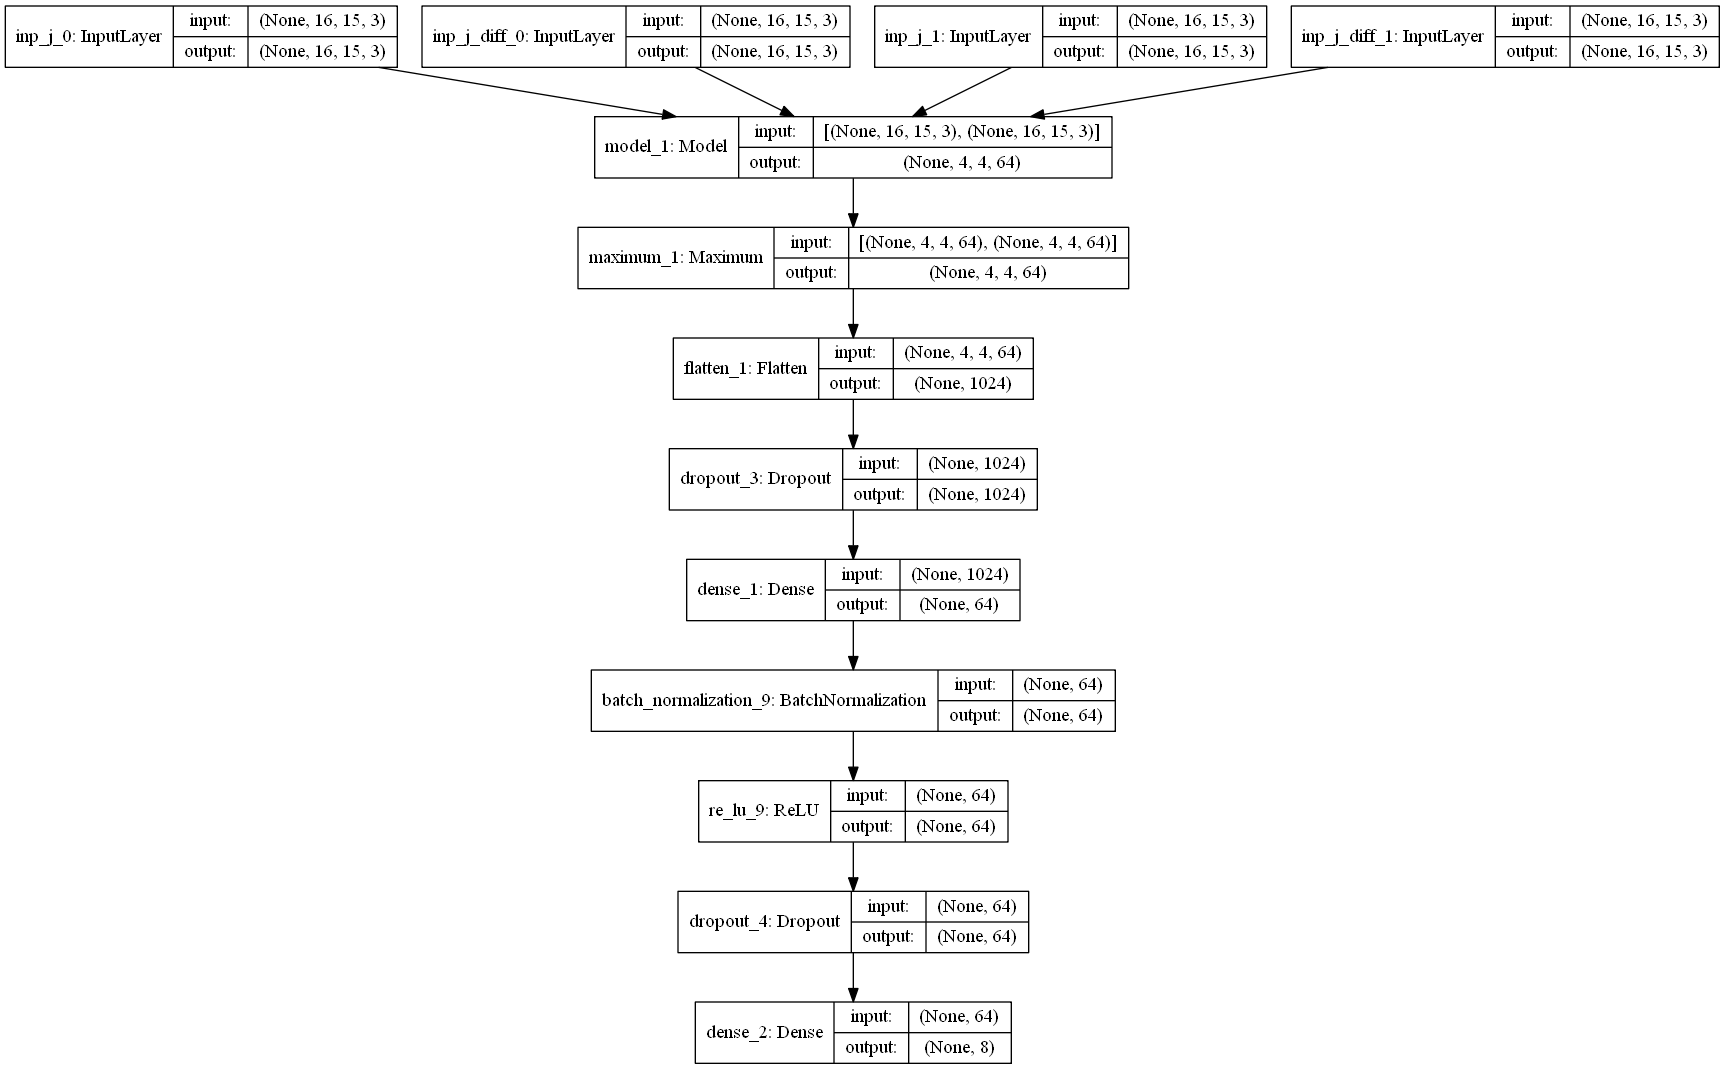

In [10]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

**Experiment 1**
With SGD, 102728 model parameters, loss is 0.0943 after 500 epochs.

**Experiment 2**
With Adam (as per paper), 102728 model parameters, loss is 

In [11]:
epochs = 500
for e in range(epochs):
    X_0 = [] 
    X_1 = []
    X_2 = []
    X_3 = []
    Y = []

    for i in range(1,9):                 # loop 8 classes
        for j in range(len(train[i])):   # loop all samples within the same class
            
            p = train[i][j]
            
            #Get two person poses
            p0, p1 = separate_persons(p)
            
            # crop or pad to reach 16 frame for each person
            p0 = auto_crop_pad(p0)
            p1 = auto_crop_pad(p1)

            # randomly mirror augmentation 
            if np.random.choice([0,1],1): 
                p0, p1 = mirror(p0, p1)

            # Calculate the temporal difference for each person
            p0_diff = temporal_diff(p0)
            p1_diff = temporal_diff(p1)

            X_0.append(p0)
            X_1.append(p0_diff)
            X_2.append(p1)
            X_3.append(p1_diff)

            label = np.zeros(8)
            label[i-1] = 1
            Y.append(label)

    X_0 = np.stack(X_0)
    X_1 = np.stack(X_1)
    X_2 = np.stack(X_2)
    X_3 = np.stack(X_3)
    Y = np.stack(Y)    

    history = model.fit([X_0,X_1,X_2,X_3],Y,batch_size=32,epochs=1,verbose=True,shuffle=True)
    
    if not (e+1)%50:
        lr *= 0.8
        adam = optimizers.Adam(lr) #.SGD(lr=lrt, momentum=0.9, decay=1e-4, nesterov=False)
        model.compile(adam, loss='mean_squared_error')

Epoch 1/1
274/274 [==============================] - 12s 46ms/step - loss: 0.2659
Epoch 1/1
274/274 [==============================] - 0s 2ms/step - loss: 0.2324
Epoch 1/1
274/274 [==============================] - 0s 2ms/step - loss: 0.2048
Epoch 1/1
274/274 [==============================] - 0s 2ms/step - loss: 0.1732
Epoch 1/1
274/274 [==============================] - 1s 2ms/step - loss: 0.1546
Epoch 1/1
274/274 [==============================] - 0s 1ms/step - loss: 0.1348
Epoch 1/1
274/274 [==============================] - 0s 1ms/step - loss: 0.1167
Epoch 1/1
274/274 [==============================] - 0s 1ms/step - loss: 0.1046
Epoch 1/1
274/274 [==============================] - 0s 1ms/step - loss: 0.0945
Epoch 1/1
274/274 [==============================] - 0s 1ms/step - loss: 0.0796
Epoch 1/1
274/274 [==============================] - 0s 1ms/step - loss: 0.0738
Epoch 1/1
274/274 [==============================] - 0s 1ms/step - loss: 0.0660
Epoch 1/1
274/274 [===================

In [12]:
X_TEST_0 = []
X_TEST_1 = []
X_TEST_2 = []
X_TEST_3 = []
Y_TEST = []

for i in range(1,9):
    for j in range(len(test[i])):
        p = test[i][j]

        #Get two person poses
        p0, p1 = separate_persons(p)

        # crop or pad to reach 16 frame for each person
        p0 = auto_crop_pad(p0)
        p1 = auto_crop_pad(p1)

        # randomly mirror augmentation 
        if np.random.choice([0,1],1): 
            p0, p1 = mirror(p0, p1)

        # Calculate the temporal difference for each person
        p0_diff = temporal_diff(p0)
        p1_diff = temporal_diff(p1)

        X_TEST_0.append(p0)
        X_TEST_1.append(p0_diff)
        X_TEST_2.append(p1)
        X_TEST_3.append(p1_diff)
        
        label = np.zeros(8)
        label[i-1] = 1
        Y_TEST.append(label)

X_TEST_0 = np.stack(X_TEST_0)
X_TEST_1 = np.stack(X_TEST_1)
X_TEST_2 = np.stack(X_TEST_2)
X_TEST_3 = np.stack(X_TEST_3)
Y_TEST = np.stack(Y_TEST)

Y_pred = model.predict([X_TEST_0,X_TEST_1,X_TEST_2,X_TEST_3])

print('Predict labels:',np.argmax(Y_pred,axis=1))
print('Ground truth labels:',np.argmax(Y_TEST,axis=1))

Predict labels: [0 1 2 0 4 5 6 7]
Ground truth labels: [0 1 2 3 4 5 6 7]
